In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
import airportsdata
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns

## Prepare Dataset

In [2]:
file_path = "bookingsData.csv"

In [3]:
df = pd.read_csv(file_path)

/var/folders/jj/3_60j1tx1ys_rfzl_xtzxnnm0000gp/T/ipykernel_6889/2618208116.py:1: DtypeWarning: Columns (31) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


In [4]:
df.head()

,Unnamed: 0,PNR,PNR_CREATE_DT,NUM_IN_PARTY,CHANNEL,ORIGIN,DEST,OD,NUM_SEGMENTS,PNR_DEPARTURE_DATE,...,departure_month_name,TRAVEL_DISTANCE,Holiday_Departure,Holiday_Return,Cumulative_Booking_Count,LENGTH_OF_STAY,WEEKEND_DEPARTURE,WEEKEND_ARRIVAL,Distance_Bin,BOOKING_WINDOW
0,80521,A196441,2022-06-28,2,DIRECT,ABE,BOS,ABE-BOS,2,2022-07-01,...,July,258.0,NaN,Independence Day,0,3 days,True,0.0,0-500,1-7 days
1,84806,A206961,2022-06-28,2,DIRECT,ABE,BOS,ABE-BOS,1,2022-07-01,...,July,258.0,NaN,NaN,1,NaN,True,NaN,0-500,1-7 days
2,280773,A688913,2022-06-30,1,DIRECT,ABE,BOS,ABE-BOS,1,2022-07-02,...,July,258.0,Independence Day,NaN,0,NaN,True,NaN,0-500,1-7 days
3,16303,A40023,2022-07-01,2,DIRECT,ABE,BOS,ABE-BOS,1,2022-07-02,...,July,258.0,Independence Day,NaN,1,NaN,True,NaN,0-500,1-7 days
4,251373,A616680,2022-07-01,2,DIRECT,ABE,BOS,ABE-BOS,1,2022-07-03,...,July,258.0,Independence Day,NaN,0,NaN,True,NaN,0-500,1-7 days


In [5]:
df = df.drop(columns = {'Unnamed: 0'})

In [6]:
df.shape

(2249589, 32)

### Correcting Travel_Distance

In [7]:
airports = airportsdata.load('IATA')
# Assume `airport_dict` is the dictionary containing airport data
airport_df = pd.DataFrame.from_dict(airports, orient='index')
airport_df = airport_df.reset_index().rename(columns={'index': 'airport_code'})

# Keep only necessary columns for merging (e.g., 'airport_code', 'lat', 'lon')
airport_df = airport_df[['iata', 'lat', 'lon']].rename(columns={'iata': 'airport_code'})

In [8]:
# Merge origin coordinates
df = df.merge(airport_df.rename(columns={'airport_code': 'ORIGIN', 'lat': 'Origin_Lat', 'lon': 'Origin_Lon'}),
              on='ORIGIN', how='left')

# Merge destination coordinates
df = df.merge(airport_df.rename(columns={'airport_code': 'DEST', 'lat': 'Dest_Lat', 'lon': 'Dest_Lon'}),
              on='DEST', how='left')

In [9]:
# Convert latitude and longitude from degrees to radians
df['Origin_Lat_rad'] = np.radians(df['Origin_Lat'])
df['Origin_Lon_rad'] = np.radians(df['Origin_Lon'])
df['Dest_Lat_rad'] = np.radians(df['Dest_Lat'])
df['Dest_Lon_rad'] = np.radians(df['Dest_Lon'])

# Haversine formula for distance calculation
def haversine_distance(lat1, lon1, lat2, lon2):
    R = 3958.8  # Radius of Earth in miles
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    return R * c

# Calculate distance using the haversine formula
df['Calculated_Travel_Distance'] = haversine_distance(df['Origin_Lat_rad'], df['Origin_Lon_rad'], 
                                                      df['Dest_Lat_rad'], df['Dest_Lon_rad'])
df['Calculated_Travel_Distance'] = df['Calculated_Travel_Distance'].round(2)

In [10]:
df.columns

Index(['PNR', 'PNR_CREATE_DT', 'NUM_IN_PARTY', 'CHANNEL', 'ORIGIN', 'DEST',
       'OD', 'NUM_SEGMENTS', 'PNR_DEPARTURE_DATE', 'PNR_RETURN_DATE',
       'BUSINESS_PROBABILITY', 'BLEISURE_PROBABILITY', 'VFR_PROBABILITY',
       'VACATION_PROBABILITY', 'PERSONAL_PROBABILITY', 'REVENUE',
       'ADVANCED_PURCHASE', 'ROUNDTRIP', 'NONSTOP', 'REVENUE_PER_PERSON',
       'TRAVEL_TYPE', 'departure_month', 'departure_month_name',
       'TRAVEL_DISTANCE', 'Holiday_Departure', 'Holiday_Return',
       'Cumulative_Booking_Count', 'LENGTH_OF_STAY', 'WEEKEND_DEPARTURE',
       'WEEKEND_ARRIVAL', 'Distance_Bin', 'BOOKING_WINDOW', 'Origin_Lat',
       'Origin_Lon', 'Dest_Lat', 'Dest_Lon', 'Origin_Lat_rad',
       'Origin_Lon_rad', 'Dest_Lat_rad', 'Dest_Lon_rad',
       'Calculated_Travel_Distance'],
      dtype='object')

In [11]:
df = df.drop(columns = ['Origin_Lat', 'Origin_Lon',
       'Dest_Lat', 'Dest_Lon', 'Origin_Lat_rad', 'Origin_Lon_rad',
       'Dest_Lat_rad', 'Dest_Lon_rad','TRAVEL_DISTANCE'])

In [12]:
df.rename(columns = {'Calculated_Travel_Distance':'TRAVEL_DISTANCE'}, inplace = True)

In [13]:
df.head()

,PNR,PNR_CREATE_DT,NUM_IN_PARTY,CHANNEL,ORIGIN,DEST,OD,NUM_SEGMENTS,PNR_DEPARTURE_DATE,PNR_RETURN_DATE,...,departure_month_name,Holiday_Departure,Holiday_Return,Cumulative_Booking_Count,LENGTH_OF_STAY,WEEKEND_DEPARTURE,WEEKEND_ARRIVAL,Distance_Bin,BOOKING_WINDOW,TRAVEL_DISTANCE
0,A196441,2022-06-28,2,DIRECT,ABE,BOS,ABE-BOS,2,2022-07-01,2022-07-04,...,July,NaN,Independence Day,0,3 days,True,0.0,0-500,1-7 days,258.03
1,A206961,2022-06-28,2,DIRECT,ABE,BOS,ABE-BOS,1,2022-07-01,NaN,...,July,NaN,NaN,1,NaN,True,NaN,0-500,1-7 days,258.03
2,A688913,2022-06-30,1,DIRECT,ABE,BOS,ABE-BOS,1,2022-07-02,NaN,...,July,Independence Day,NaN,0,NaN,True,NaN,0-500,1-7 days,258.03
3,A40023,2022-07-01,2,DIRECT,ABE,BOS,ABE-BOS,1,2022-07-02,NaN,...,July,Independence Day,NaN,1,NaN,True,NaN,0-500,1-7 days,258.03
4,A616680,2022-07-01,2,DIRECT,ABE,BOS,ABE-BOS,1,2022-07-03,NaN,...,July,Independence Day,NaN,0,NaN,True,NaN,0-500,1-7 days,258.03


### Filter Irrelevant Data

In [14]:
df.shape

(2249589, 32)

In [15]:
df = df[df['ORIGIN'] !=df['DEST']]

In [16]:
df.shape

(2249557, 32)

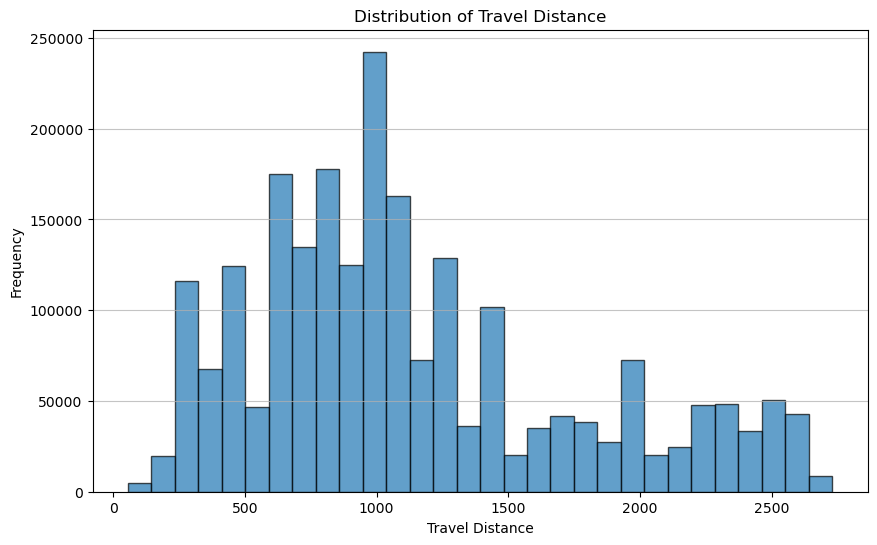

In [17]:
# Plotting the histogram
plt.figure(figsize=(10, 6))
plt.hist(df['TRAVEL_DISTANCE'].dropna(), bins=30, edgecolor='k', alpha=0.7)
plt.title('Distribution of Travel Distance')
plt.xlabel('Travel Distance')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

In [18]:
df.Distance_Bin.value_counts()

Distance_Bin
500-1000     708414
1000-1500    616656
0-500        330333
2000-3000    278914
1500-2000    226152
Name: count, dtype: int64

In [19]:
distance_bins = [0,250,500, 750, 1000, 1250, 1500, 2000, 3000, float('inf')]
distance_labels = ['0-250','250-500','500-750','750-1000','1000-1250', '1250-1500', '1500-2000', '2000-3000', '3000+']
df['Distance_Bin'] = pd.cut(df['TRAVEL_DISTANCE'], bins=distance_bins, labels=distance_labels)

### Capturing Willingness to Pay by adding Interaction features and more columns

#### 1. Revenue & Price Columns

In [20]:
df['RPM'] = df['REVENUE_PER_PERSON'] / df['TRAVEL_DISTANCE']
#df['Inverse_AP'] = 1 / df['ADVANCED_PURCHASE'] # have some infinity value

In [21]:
df['RPM_CumulativeBookings_Interaction'] = df['RPM'] * (df['Cumulative_Booking_Count']+1)# Weekend Interaction: Captures WTP for trips with either weekend departure or arrival

#### 2. Revenue AP Ratio
##### Higher values of Revenue_AP_Ratio imply higher WTP due to more urgency and willingness to pay despite minimal advance purchase time

In [22]:
df['Revenue_AP_Ratio'] = df['RPM'] / (df['ADVANCED_PURCHASE'] + 1)

#### 3. Distance_Adjusted_Revenue
##### how much a customer pays relative to the typical price within their distance bin. This approach identifies customers willing to pay a premium over the norm for their travel distance, which is a strong WTP indicator.

In [23]:
# Calculate average revenue per distance bin
avg_revenue_per_bin = df.groupby('Distance_Bin')['REVENUE_PER_PERSON'].transform('mean')
df['Distance_Adjusted_Revenue'] = df['REVENUE_PER_PERSON'] / avg_revenue_per_bin

/var/folders/jj/3_60j1tx1ys_rfzl_xtzxnnm0000gp/T/ipykernel_6889/3843558282.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_revenue_per_bin = df.groupby('Distance_Bin')['REVENUE_PER_PERSON'].transform('mean')


#### 4. Cumulative_Advance_Purchase_Ratio
##### a higher cumulative count with a shorter AP signals a higher WTP, as demand is driving up booking rates.

In [24]:
df['Cumulative_Advance_Purchase_Ratio'] = df['Cumulative_Booking_Count'] + 1/ (df['ADVANCED_PURCHASE'] + 1)

#### 5. Channel RPM Ratio
##### reflect the willingness to pay per mile relative to the average for each booking channel

In [25]:
avg_rpm_per_channel = df.groupby('CHANNEL')['RPM'].transform('mean')

# Calculate Channel-Based RPM Premium (Channel_RPM_Ratio)
df['Channel_RPM_Ratio'] = df['RPM'] / avg_rpm_per_channel

In [26]:
df.Channel_RPM_Ratio.isna().sum()

0

In [27]:
df.Distance_Adjusted_Revenue.isna().sum()

0

In [28]:
df.head()

,PNR,PNR_CREATE_DT,NUM_IN_PARTY,CHANNEL,ORIGIN,DEST,OD,NUM_SEGMENTS,PNR_DEPARTURE_DATE,PNR_RETURN_DATE,...,WEEKEND_ARRIVAL,Distance_Bin,BOOKING_WINDOW,TRAVEL_DISTANCE,RPM,RPM_CumulativeBookings_Interaction,Revenue_AP_Ratio,Distance_Adjusted_Revenue,Cumulative_Advance_Purchase_Ratio,Channel_RPM_Ratio
0,A196441,2022-06-28,2,DIRECT,ABE,BOS,ABE-BOS,2,2022-07-01,2022-07-04,...,0.0,250-500,1-7 days,258.03,0.367729,0.367729,0.091932,0.603647,0.250000,1.622503
1,A206961,2022-06-28,2,DIRECT,ABE,BOS,ABE-BOS,1,2022-07-01,NaN,...,NaN,250-500,1-7 days,258.03,0.277603,0.555207,0.069401,0.455701,1.250000,1.224850
2,A688913,2022-06-30,1,DIRECT,ABE,BOS,ABE-BOS,1,2022-07-02,NaN,...,NaN,250-500,1-7 days,258.03,0.418750,0.418750,0.139583,0.687401,0.333333,1.847620
3,A40023,2022-07-01,2,DIRECT,ABE,BOS,ABE-BOS,1,2022-07-02,NaN,...,NaN,250-500,1-7 days,258.03,0.241542,0.483083,0.120771,0.396504,1.500000,1.065738
4,A616680,2022-07-01,2,DIRECT,ABE,BOS,ABE-BOS,1,2022-07-03,NaN,...,NaN,250-500,1-7 days,258.03,0.241542,0.241542,0.080514,0.396504,0.333333,1.065738


In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2249557 entries, 0 to 2249588
Data columns (total 38 columns):
 #   Column                              Dtype   
---  ------                              -----   
 0   PNR                                 object  
 1   PNR_CREATE_DT                       object  
 2   NUM_IN_PARTY                        int64   
 3   CHANNEL                             object  
 4   ORIGIN                              object  
 5   DEST                                object  
 6   OD                                  object  
 7   NUM_SEGMENTS                        int64   
 8   PNR_DEPARTURE_DATE                  object  
 9   PNR_RETURN_DATE                     object  
 10  BUSINESS_PROBABILITY                float64 
 11  BLEISURE_PROBABILITY                float64 
 12  VFR_PROBABILITY                     float64 
 13  VACATION_PROBABILITY                float64 
 14  PERSONAL_PROBABILITY                float64 
 15  REVENUE                             f

##### overview values of some columns

In [30]:
df['BOOKING_WINDOW'].value_counts()

BOOKING_WINDOW
21+ days      1291734
1-7 days       428082
8-14 days      249040
15-21 days     212277
Name: count, dtype: int64

In [31]:
df['Distance_Bin'].value_counts()

Distance_Bin
750-1000     447133
1000-1250    393545
500-750      331761
2000-3000    278829
250-500      271846
1250-1500    251169
1500-2000    228789
0-250         46485
3000+             0
Name: count, dtype: int64

In [32]:
df['WEEKEND_ARRIVAL'].unique()

array([ 0., nan,  1.])

In [33]:
df['WEEKEND_DEPARTURE'].unique()

array([ True, False])

In [34]:
print(df['ROUNDTRIP'].dtype)

bool


In [35]:
print(df['NONSTOP'].dtype)

bool


#### Converting WEEKEND_ARRIVAL, WEEKEND_DEPARTURE, Holiday_Departure, Holiday_Return, ROUNDTRIP, NONSTOP Data types

In [36]:
# Replace NaN values with 0 in WEEKEND_ARRIVAL
# NaN values in pandas are represented as np.nan (special floating-point value), not as the string 'NaN'
df['WEEKEND_ARRIVAL'].fillna(0, inplace=True)
df['WEEKEND_ARRIVAL'].unique()

array([0., 1.])

In [37]:
# Convert WEEKEND_DEPARTURE from bool to integer
df['WEEKEND_DEPARTURE'] = df['WEEKEND_DEPARTURE'].astype(int)
print(df['WEEKEND_DEPARTURE'].dtype)

int64


In [38]:
# Convert Holiday_Departure: NaN becomes 0, others become 1
df['Holiday_Departure'] = np.where(df['Holiday_Departure'].isna(), 0, 1).astype(int)
df['Holiday_Departure'].unique()

array([0, 1])

In [39]:
# Conver Holiday_Return: nan -> 0, else ->1
df['Holiday_Return'] = np.where(df['Holiday_Return'].isna(), 0, 1).astype(int)
df['Holiday_Return'].unique()

array([1, 0])

In [40]:
#Convert ROUNDTRIP from boolean to integer
df['ROUNDTRIP'] = df['ROUNDTRIP'].astype(int)
print(df['ROUNDTRIP'].dtype)

int64


In [41]:
#Covert NONSTOP from boolean to integer
df['NONSTOP'] = df['NONSTOP'].astype(int)
print(df['NONSTOP'].dtype)

int64


In [42]:
df.nunique()

PNR                                   2249557
PNR_CREATE_DT                             514
NUM_IN_PARTY                               58
CHANNEL                                     6
ORIGIN                                    205
DEST                                      205
OD                                       4072
NUM_SEGMENTS                                4
PNR_DEPARTURE_DATE                        184
PNR_RETURN_DATE                           245
BUSINESS_PROBABILITY                     4101
BLEISURE_PROBABILITY                     3898
VFR_PROBABILITY                          9733
VACATION_PROBABILITY                     9831
PERSONAL_PROBABILITY                     7476
REVENUE                                 75413
ADVANCED_PURCHASE                         331
ROUNDTRIP                                   2
NONSTOP                                     2
REVENUE_PER_PERSON                      63322
TRAVEL_TYPE                                 3
departure_month                   

In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2249557 entries, 0 to 2249588
Data columns (total 38 columns):
 #   Column                              Dtype   
---  ------                              -----   
 0   PNR                                 object  
 1   PNR_CREATE_DT                       object  
 2   NUM_IN_PARTY                        int64   
 3   CHANNEL                             object  
 4   ORIGIN                              object  
 5   DEST                                object  
 6   OD                                  object  
 7   NUM_SEGMENTS                        int64   
 8   PNR_DEPARTURE_DATE                  object  
 9   PNR_RETURN_DATE                     object  
 10  BUSINESS_PROBABILITY                float64 
 11  BLEISURE_PROBABILITY                float64 
 12  VFR_PROBABILITY                     float64 
 13  VACATION_PROBABILITY                float64 
 14  PERSONAL_PROBABILITY                float64 
 15  REVENUE                             f

In [44]:
df2 = df.copy()

In [45]:
# Encode categorical variables - ordinal encode
label_encoder = LabelEncoder()
df2['CHANNEL'] = label_encoder.fit_transform(df2['CHANNEL'])
df2['ORIGIN'] = label_encoder.fit_transform(df2['ORIGIN'])
df2['DEST'] = label_encoder.fit_transform(df2['DEST'])
df2['OD'] = label_encoder.fit_transform(df2['OD'])
df2['TRAVEL_TYPE'] = label_encoder.fit_transform(df2['TRAVEL_TYPE'])
df2['departure_month'] = label_encoder.fit_transform(df2['departure_month'])
df2['Distance_Bin'] = label_encoder.fit_transform(df2['Distance_Bin'])
df2['BOOKING_WINDOW'] = label_encoder.fit_transform(df2['BOOKING_WINDOW'])


In [46]:
df2.sample(10)

,PNR,PNR_CREATE_DT,NUM_IN_PARTY,CHANNEL,ORIGIN,DEST,OD,NUM_SEGMENTS,PNR_DEPARTURE_DATE,PNR_RETURN_DATE,...,WEEKEND_ARRIVAL,Distance_Bin,BOOKING_WINDOW,TRAVEL_DISTANCE,RPM,RPM_CumulativeBookings_Interaction,Revenue_AP_Ratio,Distance_Adjusted_Revenue,Cumulative_Advance_Purchase_Ratio,Channel_RPM_Ratio
653105,A59565,2022-09-17,1,1,55,176,1014,1,2022-10-14,NaN,...,0.0,6,2,731.79,0.374998,14.624933,0.013393,1.796118,38.035714,1.654579
1124436,D498141,2022-07-26,1,1,118,143,2240,1,2022-12-03,NaN,...,0.0,1,2,1006.65,0.146009,1.314081,0.001115,0.789841,8.007634,0.644226
1999575,C418806,2022-10-31,4,3,176,118,3461,2,2022-11-04,2022-11-06,...,1.0,6,0,719.95,0.142774,1.427738,0.028555,0.672775,9.200000,0.833999
202992,D13675,2022-07-27,2,1,25,138,440,1,2022-08-06,NaN,...,0.0,6,3,738.08,0.111539,1.338473,0.010140,0.538829,11.090909,0.492138
575018,B149683,2022-05-13,2,1,55,129,1005,1,2022-07-08,NaN,...,0.0,6,2,691.10,0.523600,1.570800,0.009186,2.368425,2.017544,2.310244
1658589,D155578,2022-10-26,1,3,150,126,2858,1,2022-11-04,NaN,...,0.0,1,3,1015.35,0.228128,67.754085,0.022813,1.244734,296.100000,1.332589
2118714,C326211,2022-07-18,2,1,183,143,3642,1,2022-10-25,NaN,...,0.0,1,2,1246.41,0.100753,0.201507,0.001008,0.674842,1.010000,0.444547
832839,B355291,2022-08-08,2,1,84,169,1558,1,2022-08-25,NaN,...,0.0,1,1,1168.09,0.104324,0.208648,0.005796,0.654851,1.055556,0.460302
1162348,B507006,2022-09-23,2,1,120,151,2289,1,2022-11-24,NaN,...,0.0,2,2,1260.97,0.051270,0.717781,0.000814,0.319641,13.015873,0.226215
765707,D702045,2022-10-26,2,1,66,55,1243,1,2022-12-05,NaN,...,0.0,1,2,1088.56,0.138867,0.694335,0.003387,0.812331,4.024390,0.612713


In [47]:
# Exclude dates, departure_month_name, REVENUE, LENGTH_OF_STAY
df_numeric = df2[['NUM_IN_PARTY','CHANNEL', 'ORIGIN', 'DEST', 'OD', 'NUM_SEGMENTS', 'VFR_PROBABILITY',
                 'VACATION_PROBABILITY', 'PERSONAL_PROBABILITY', 'ADVANCED_PURCHASE', 
                 'ROUNDTRIP','NONSTOP','REVENUE_PER_PERSON','TRAVEL_TYPE', 'departure_month', 'TRAVEL_DISTANCE',
                 'Holiday_Departure', 'Holiday_Return', 'Cumulative_Booking_Count',
                 'WEEKEND_DEPARTURE', 'WEEKEND_ARRIVAL', 'Distance_Bin', 'BOOKING_WINDOW',
                 'Cumulative_Advance_Purchase_Ratio' ]]
df_numeric.head()

# Take off 'Channel_RPM_Ratio', 'RPM', 'RPM_CumulativeBookings_Interaction','Distance_Adjusted_Revenue','Revenue_AP_Ratio'
# The features removed are more predictive of Revenue per Person (RPP) compared to non-WTP features, as they directly involve RPP in their computation.

,NUM_IN_PARTY,CHANNEL,ORIGIN,DEST,OD,NUM_SEGMENTS,VFR_PROBABILITY,VACATION_PROBABILITY,PERSONAL_PROBABILITY,ADVANCED_PURCHASE,...,departure_month,TRAVEL_DISTANCE,Holiday_Departure,Holiday_Return,Cumulative_Booking_Count,WEEKEND_DEPARTURE,WEEKEND_ARRIVAL,Distance_Bin,BOOKING_WINDOW,Cumulative_Advance_Purchase_Ratio
0,2,1,0,25,0,2,0.7196,0.1549,0.0818,3,...,0,258.03,0,1,0,1,0.0,5,0,0.250000
1,2,1,0,25,0,1,0.8315,0.0781,0.0459,3,...,0,258.03,0,0,1,1,0.0,5,0,1.250000
2,1,1,0,25,0,1,0.5196,0.0939,0.2188,2,...,0,258.03,1,0,0,1,0.0,5,0,0.333333
3,2,1,0,25,0,1,0.5615,0.1940,0.0780,1,...,0,258.03,1,0,1,1,0.0,5,0,1.500000
4,2,1,0,25,0,1,0.4436,0.0860,0.2535,2,...,0,258.03,1,0,0,1,0.0,5,0,0.333333


In [48]:
df_numeric['Holiday_Departure'].value_counts() #originally: holiday names

Holiday_Departure
0    1979961
1     269596
Name: count, dtype: int64

In [49]:
df_numeric.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2249557 entries, 0 to 2249588
Data columns (total 24 columns):
 #   Column                             Dtype  
---  ------                             -----  
 0   NUM_IN_PARTY                       int64  
 1   CHANNEL                            int64  
 2   ORIGIN                             int64  
 3   DEST                               int64  
 4   OD                                 int64  
 5   NUM_SEGMENTS                       int64  
 6   VFR_PROBABILITY                    float64
 7   VACATION_PROBABILITY               float64
 8   PERSONAL_PROBABILITY               float64
 9   ADVANCED_PURCHASE                  int64  
 10  ROUNDTRIP                          int64  
 11  NONSTOP                            int64  
 12  REVENUE_PER_PERSON                 float64
 13  TRAVEL_TYPE                        int64  
 14  departure_month                    int64  
 15  TRAVEL_DISTANCE                    float64
 16  Holiday_Departure      

In [50]:
df_numeric['BOOKING_WINDOW'].value_counts() # the result of ordinal encode: assign numbers

BOOKING_WINDOW
2    1291734
0     428082
3     249040
1     212277
4      68424
Name: count, dtype: int64

In [51]:
df_numeric['Distance_Bin'].value_counts()

Distance_Bin
7    447133
1    393545
6    331761
4    278829
5    271846
2    251169
3    228789
0     46485
Name: count, dtype: int64

In [52]:
df_numeric['ORIGIN'].value_counts() #DEST, OD

ORIGIN
55     194735
150    193628
126    112497
143    106923
25      84804
        ...  
26        117
187       105
48         70
116        31
145         5
Name: count, Length: 205, dtype: int64

In [53]:
#Scale the feature

# List of numerical and categorical columns to standardize
numeric_categorical = ['NUM_IN_PARTY','CHANNEL', 'ORIGIN', 'DEST', 'OD', 'NUM_SEGMENTS', 'VFR_PROBABILITY',
                 'VACATION_PROBABILITY', 'PERSONAL_PROBABILITY', 'ADVANCED_PURCHASE', 
                 'REVENUE_PER_PERSON','TRAVEL_TYPE', 'departure_month', 'TRAVEL_DISTANCE',
                 'Cumulative_Booking_Count', 'Distance_Bin', 'BOOKING_WINDOW',
                 'Cumulative_Advance_Purchase_Ratio']


# Standardize numerical and categorical data
scaler = StandardScaler()
df_numeric[numeric_categorical] = scaler.fit_transform(df_numeric[numeric_categorical])

df_numeric.head()

/var/folders/jj/3_60j1tx1ys_rfzl_xtzxnnm0000gp/T/ipykernel_6889/431004941.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_numeric[numeric_categorical] = scaler.fit_transform(df_numeric[numeric_categorical])


,NUM_IN_PARTY,CHANNEL,ORIGIN,DEST,OD,NUM_SEGMENTS,VFR_PROBABILITY,VACATION_PROBABILITY,PERSONAL_PROBABILITY,ADVANCED_PURCHASE,...,departure_month,TRAVEL_DISTANCE,Holiday_Departure,Holiday_Return,Cumulative_Booking_Count,WEEKEND_DEPARTURE,WEEKEND_ARRIVAL,Distance_Bin,BOOKING_WINDOW,Cumulative_Advance_Purchase_Ratio
0,-0.060420,-0.641693,-1.930227,-1.553345,-1.855205,3.629245,1.121879,-0.623937,-0.103495,-0.822217,...,-1.425953,-1.407243,0,1,-0.580061,1,0.0,0.413825,-1.700107,-0.577062
1,-0.060420,-0.641693,-1.930227,-1.553345,-1.855205,-0.275297,1.605440,-0.917957,-0.541312,-0.822217,...,-1.425953,-1.407243,0,0,-0.561664,1,0.0,0.413825,-1.700107,-0.558680
2,-0.746804,-0.641693,-1.930227,-1.553345,-1.855205,-0.275297,0.257606,-0.857469,1.567282,-0.841602,...,-1.425953,-1.407243,1,0,-0.580061,1,0.0,0.413825,-1.700107,-0.575530
3,-0.060420,-0.641693,-1.930227,-1.553345,-1.855205,-0.275297,0.438671,-0.474247,-0.149838,-0.860987,...,-1.425953,-1.407243,1,0,-0.561664,1,0.0,0.413825,-1.700107,-0.554085
4,-0.060420,-0.641693,-1.930227,-1.553345,-1.855205,-0.275297,-0.070818,-0.887713,1.990464,-0.841602,...,-1.425953,-1.407243,1,0,-0.580061,1,0.0,0.413825,-1.700107,-0.575530


In [54]:
df_numeric.shape

(2249557, 24)

In [55]:
# Check for na value
(df_numeric.isna()).sum()

NUM_IN_PARTY                         0
CHANNEL                              0
ORIGIN                               0
DEST                                 0
OD                                   0
NUM_SEGMENTS                         0
VFR_PROBABILITY                      0
VACATION_PROBABILITY                 0
PERSONAL_PROBABILITY                 0
ADVANCED_PURCHASE                    0
ROUNDTRIP                            0
NONSTOP                              0
REVENUE_PER_PERSON                   0
TRAVEL_TYPE                          0
departure_month                      0
TRAVEL_DISTANCE                      0
Holiday_Departure                    0
Holiday_Return                       0
Cumulative_Booking_Count             0
WEEKEND_DEPARTURE                    0
WEEKEND_ARRIVAL                      0
Distance_Bin                         0
BOOKING_WINDOW                       0
Cumulative_Advance_Purchase_Ratio    0
dtype: int64

In [56]:
# Error in model1.fit(X_train, y_train) => has nan error
# Check for missing values in each column
#missing_values = X.isna().sum()
#print(missing_values[missing_values > 0])


## Define Features & Target Variables

In [57]:
# Create a proxy target: to find important features for determining REVENUE_PER_PERSON => use that as target

# Define features and target

X = df_numeric.drop(columns=['REVENUE_PER_PERSON'])  # Features
y = df_numeric['REVENUE_PER_PERSON']  # Target

## Split Train & Test Data

In [58]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

## Model: Random Forest Regressor (Target variable is continuous variable)

In [59]:
model1 = RandomForestRegressor(n_estimators=100, random_state=42)

## Train Model1

In [60]:
model1.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

## Get Variable Importance

In [61]:
# Get feature importances
importances = model1.feature_importances_

# Create a dataFrame to visualize
feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances
})

# Sort by importance
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)
print(feature_importances)


                              Feature  Importance
22  Cumulative_Advance_Purchase_Ratio    0.144423
14                    TRAVEL_DISTANCE    0.118977
6                     VFR_PROBABILITY    0.118775
7                VACATION_PROBABILITY    0.109239
8                PERSONAL_PROBABILITY    0.108125
9                   ADVANCED_PURCHASE    0.097474
17           Cumulative_Booking_Count    0.063410
13                    departure_month    0.039795
3                                DEST    0.038533
0                        NUM_IN_PARTY    0.035959
4                                  OD    0.032172
1                             CHANNEL    0.028599
2                              ORIGIN    0.017440
18                  WEEKEND_DEPARTURE    0.013086
15                  Holiday_Departure    0.010545
21                     BOOKING_WINDOW    0.008078
20                       Distance_Bin    0.003867
12                        TRAVEL_TYPE    0.002523
19                    WEEKEND_ARRIVAL    0.002256


## Visualize Variable Importance

In [62]:
#Color palette

primary_colors = ['#36495A', '#9DA6AB' ,'#0078D2'] 
cmap = mcolors.LinearSegmentedColormap.from_list('AA_Gradient', primary_colors, N=256)
num_colors = 20
extended_palette = [cmap(i / (num_colors - 1)) for i in range(num_colors)] 

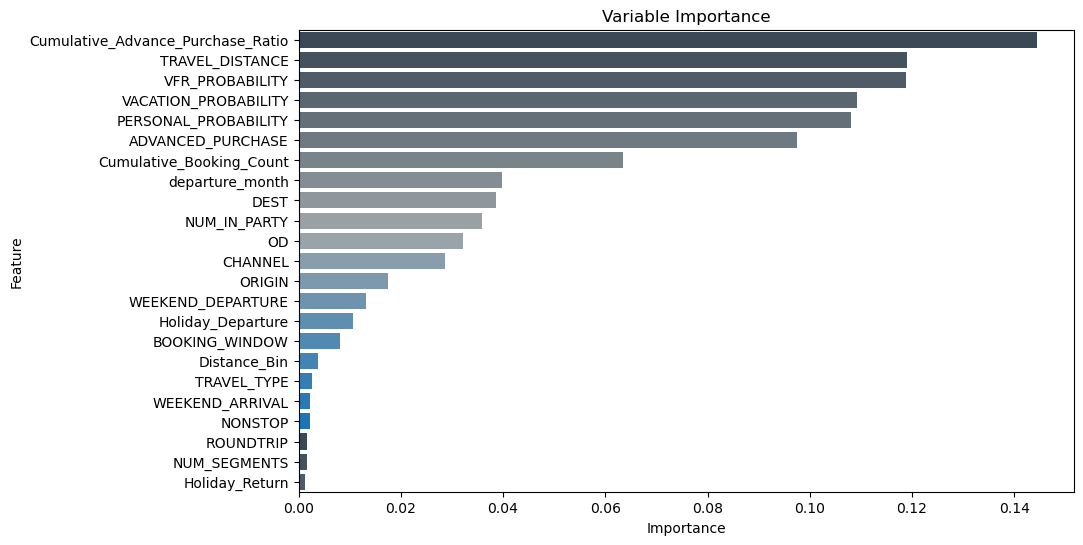

In [63]:
# Visualize ranking

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importances, palette=extended_palette)
plt.title('Variable Importance')
plt.show()
